In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd

In [3]:
from ase.build import bulk

In [4]:
from ase.optimize import BFGS, FIRE
from ase.constraints import ExpCellFilter

In [5]:
from ase.phonons import Phonons

In [6]:
import os

In [7]:
# os.environ['CUDA_VISIBLE_DEVICES']='-1' # to disable GPU usage
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [8]:
from tensorpotential.calculator import TPCalculator

# Load TPCalculator

In [9]:
calc=TPCalculator("../1-fit/seed/1/saved_model/")

In [10]:
al=bulk('Al')

In [11]:
al.calc=calc

In [12]:
al.get_potential_energy()

I0000 00:00:1731878500.301746 1587698 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


-3.745700969704617

In [13]:
BFGS(ExpCellFilter(al)).run()

      Step     Time          Energy         fmax
BFGS:    0 22:21:40       -3.745701        0.0719
BFGS:    1 22:21:40       -3.745885        0.0477


True

In [14]:
li=bulk('Li')

In [15]:
li.calc=calc

In [16]:
li.get_potential_energy()

-1.911835189706539

In [17]:
BFGS(ExpCellFilter(li)).run()

      Step     Time          Energy         fmax
BFGS:    0 22:21:40       -1.911835        0.0923
BFGS:    1 22:21:40       -1.912187        0.0856
BFGS:    2 22:21:40       -1.914217        0.0061


True

# Phonons

Example from https://wiki.fysik.dtu.dk/ase/ase/phonons.html

## Al

In [18]:
! rm -rf phonon/

In [19]:
# Phonon calculator
N = 7
ph = Phonons(al, calc, supercell=(N, N, N), delta=0.05)
ph.run()

In [20]:
# Read forces and assemble the dynamical matrix
ph.read(acoustic=True)
ph.clean()

7

In [21]:
path = al.cell.bandpath( npoints=100)
bs = ph.get_band_structure(path)

dos = ph.get_dos(kpts=(20, 20, 20)).sample_grid(npts=100, width=1e-3)

WARNING, 3 imaginary frequencies at q = ( 0.00,  0.00,  0.00) ; (omega_q = 1.561e-08*i)
WARNING, 3 imaginary frequencies at q = ( 0.00,  0.00,  0.00) ; (omega_q = 1.561e-08*i)


Text(0.5, 0, 'DOS')

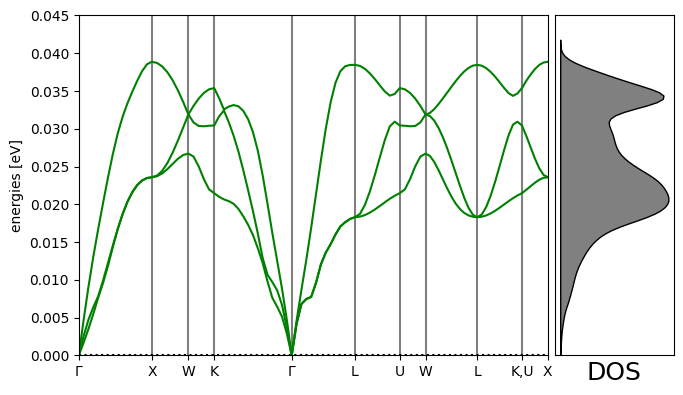

In [22]:
fig = plt.figure(1, figsize=(7, 4))
ax = fig.add_axes([.12, .07, .67, .85])

emax = 0.045
bs.plot(ax=ax, emin=0.0, emax=emax)

dosax = fig.add_axes([.8, .07, .17, .85])
dosax.fill_between(dos.get_weights(), dos.get_energies(), y2=0, color='grey',
                   edgecolor='k', lw=1)

dosax.set_ylim(0, emax)
dosax.set_yticks([])
dosax.set_xticks([])
dosax.set_xlabel("DOS", fontsize=18)

## Li

In [23]:
! rm -rf phonon/

In [24]:
# Phonon calculator
N = 7
ph = Phonons(li, calc, supercell=(N, N, N), delta=0.05)
ph.run()

# Read forces and assemble the dynamical matrix
ph.read(acoustic=True)
ph.clean()

7

In [25]:
path = li.cell.bandpath( npoints=100)
bs = ph.get_band_structure(path)

dos = ph.get_dos(kpts=(20, 20, 20)).sample_grid(npts=100, width=1e-3)

WARNING, 1 imaginary frequencies at q = ( 0.00,  0.00,  0.00) ; (omega_q = 8.137e-09*i)
WARNING, 1 imaginary frequencies at q = ( 0.00,  0.00,  0.00) ; (omega_q = 8.137e-09*i)


Text(0.5, 0, 'DOS')

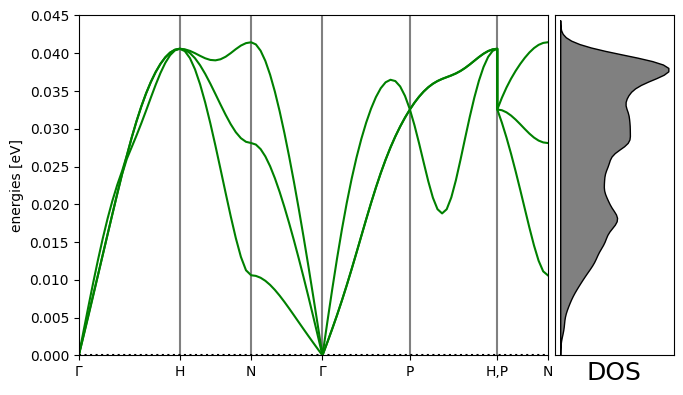

In [26]:
fig = plt.figure(1, figsize=(7, 4))
ax = fig.add_axes([.12, .07, .67, .85])

emax = 0.045
bs.plot(ax=ax, emin=0.0, emax=emax)

dosax = fig.add_axes([.8, .07, .17, .85])
dosax.fill_between(dos.get_weights(), dos.get_energies(), y2=0, color='grey',
                   edgecolor='k', lw=1)

dosax.set_ylim(0, emax)
dosax.set_yticks([])
dosax.set_xticks([])
dosax.set_xlabel("DOS", fontsize=18)

# Ensemble calculator

In [27]:
calc_ens=TPCalculator(model=[
            "../1-fit/seed/1/saved_model/",
             "../1-fit/seed/2/saved_model/",
             "../1-fit/seed/3/saved_model/",
    ]
)

In [28]:
element="Al"

In [29]:
a_list=np.linspace(1.0, 8, num=75)

energy_list=[]
estd_list=[]

for a in a_list:
    at = bulk(element,"fcc",a=a)
    at.calc=calc_ens
    
    e=at.get_potential_energy()
    estd=at.calc.results['energy_std']
    
    energy_list.append(e)
    estd_list.append(estd)

In [30]:
estd_list=np.array(estd_list)
energy_list=np.array(energy_list)

In [31]:
e_std_threshold = 10.e-3

In [32]:
mask = estd_list<e_std_threshold

Text(0, 0.5, 'E-std, eV/atom')

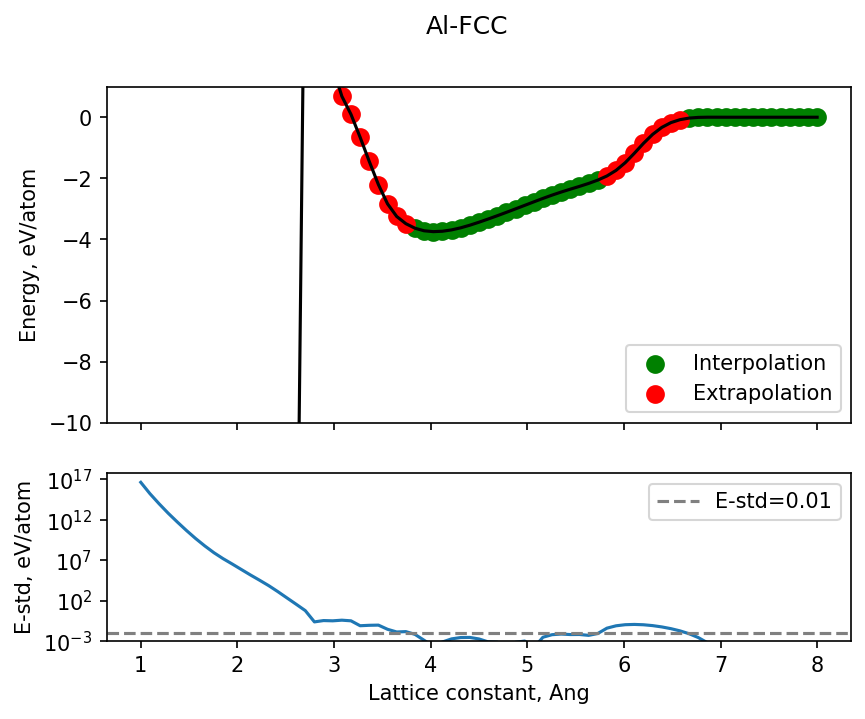

In [33]:
fig, axs= plt.subplots(nrows=2, ncols=1, sharex=True, height_ratios = [2,1], dpi=150)

fig.suptitle(element+"-FCC")
#### energy ###
axs[0].plot(a_list, energy_list, color='black')
axs[0].scatter(a_list[mask], energy_list[mask], lw=3, color="green", label='Interpolation')
axs[0].scatter(a_list[~mask], energy_list[~mask], lw=3, color="red", label='Extrapolation')

axs[0].legend()
# axs[0].set_yscale('symlog')
axs[0].set_ylabel("Energy, eV/atom")
axs[0].set_ylim(-10,1)
#### gamma ###
axs[1].plot(a_list, estd_list)
axs[1].set_yscale('log');
axs[1].set_xlabel("Lattice constant, Ang")


axs[1].axhline(e_std_threshold, ls='--', color='gray', label=f'E-std={e_std_threshold}')
axs[1].legend()
axs[1].set_ylim(min(0.1,0.1*e_std_threshold), None)
axs[1].set_ylabel("E-std, eV/atom")